# Coming from TensorFlow to NengoDL

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/from-tensorflow.ipynb)

NengoDL combines two frameworks: Nengo and TensorFlow.  This tutorial is designed for people who are familiar with TensorFlow and looking to learn more about neuromorphic modelling with NengoDL.  For the other approach, users familiar with Nengo looking to learn how to use NengoDL, check out [this tutorial](https://www.nengo.ai/nengo-dl/examples/from-nengo.html).

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import nengo
from nengo.utils.matplotlib import rasterplot
import numpy as np
import tensorflow as tf

import nengo_dl


warnings.simplefilter("ignore")
tf.get_logger().addFilter(lambda rec: "Tracing is expensive" not in rec.msg)

## What is Nengo

We'll start with the very basics, where you might be wondering what Nengo is and why you would want to use it.  Nengo is a tool for constructing and simulating neural networks.  That is, to some extent, the same purpose as TensorFlow (and its higher level API, Keras).  For example, here is how we might build a simple two layer auto-encoder network in TensorFlow:

In [2]:
n_in = 784
n_hidden = 64
minibatch_size = 50

# input
tf_a = tf.keras.Input(shape=(n_in,))

# first layer
tf_b = tf.keras.layers.Dense(
    n_hidden, activation=tf.nn.relu,
    kernel_initializer=tf.initializers.glorot_uniform()
)(tf_a)

# second layer
tf_c = tf.keras.layers.Dense(
    n_in, activation=tf.nn.relu,
    kernel_initializer=tf.initializers.glorot_uniform()
)(tf_b)

And here is how we would build the same network architecture in Nengo:

In [3]:
with nengo.Network() as auto_net: 
    # input
    nengo_a = nengo.Node(np.zeros(n_in))
    
    # first layer
    nengo_b = nengo.Ensemble(
        n_hidden, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_a, nengo_b.neurons, transform=nengo_dl.dists.Glorot())
    
    # second layer
    nengo_c = nengo.Ensemble(
        n_in, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_b.neurons, nengo_c.neurons, 
        transform=nengo_dl.dists.Glorot())
    
    # probes are used to collect data from the network
    p_c = nengo.Probe(nengo_c.neurons)

One difference you'll note is that with Nengo we separate the creation of the layers and the creation of the connections between layers.  This is because the connection structure in Nengo networks often has a lot more state and general complexity than in typical deep learning networks, so it is helpful to be able to control it independently (we'll see examples of this later).

Another new object you may notice is the `nengo.Probe`.  This is used to collect data from the simulation; by adding a probe to `nengo_c.neurons`, we are indicating that we want to collect the activities of those neurons when the simulation is running.  You can think of this like the `outputs` arguments in a Keras Model.

We will not go into a lot of detail on Nengo here; there is much more functionality available, but we will focus on the features most familiar or relevant to those coming from a TensorFlow background.  For a more in-depth introduction to Nengo, check out the Nengo-specific [documentation](https://www.nengo.ai/nengo/) and [examples](https://www.nengo.ai/nengo/examples.html).

## Simulating a network

To simulate a Keras network we create a `Model` and call `model.predict`:

In [4]:
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
model.predict(np.ones((minibatch_size, n_in)));

Again, accomplishing the same thing in Nengo bears many similarities.  We create a `Simulator` and call `sim.predict`:

In [5]:
with nengo_dl.Simulator(network=auto_net, 
                        minibatch_size=minibatch_size) as sim:
    sim.predict(np.ones((minibatch_size, 1, n_in)));

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###########   Constructing graph: build stage (18%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

| #                       Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###########   Constructing graph: build stage (18%)             | ETA: 0:00:00

|##############Constructing graph: build stage (45%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

One difference you may note is the extra dimension with size 1 in the shape of the Nengo inputs.  This represents the time dimension; in this example we're only running for a single timestep, which is why it has size 1, but this could be used to provide different input values on each simulation timestep.

This highlights a key difference between Nengo and TensorFlow.  Nengo simulations are fundamentally temporal in nature; unlike TensorFlow where the graph simply represents an abstract set of computations, in Nengo we (almost) always think of the graph as representing a stateful neural simulation, where values are accumulated, updated, and communicated over time.  This is not to say there is no overlap (we can create TensorFlow simulations that execute over time, and we can create Nengo simulations without temporal dynamics), but this is a different way of thinking about computations that influences how we construct and simulate networks in Nengo.

More details on the NengoDL Simulator can be found in [the user guide](https://www.nengo.ai/nengo-dl/simulator.html).

## Spiking networks

Although Nengo can be used to create TensorFlow-style networks, it has been primarily designed for a different style of modelling: "neuromorphic" networks.  Neuromorphic networks include features drawn from biological neural networks, in an effort to understand or recreate the functionality of biological brains.  Note that these models fall on a spectrum with standard artificial neural networks, with different approaches incorporating different biological features.  But in general the structure and parameterization of these networks often differs significantly from standard deep network architectures.

We touched on this above in the discussion of temporality, which is one common feature of neuromorphic networks.  Another common characteristic is the use of more complicated neuron models, in particular spiking neurons.  In contrast to "rate" neurons (like `relu`) that output a continuous value, spiking neurons communicate via discrete bursts of output called spikes.

We can visualize this difference with a simple 1-layer network. In this example we'll use `sim.run_steps` to run the simulation, rather than `sim.predict`.  `sim.run_steps` (or `sim.run`) is a standard Nengo Simulator execution function (as opposed to `sim.predict`, which is specific to NengoDL).  We could use either one, but you will probably see `sim.run` in Nengo code, so we introduce it here.  The main difference in this case is that results will be stored in the `sim.data` dictionary, as opposed to being returned directly from `sim.predict`.

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|####          Constructing graph: build stage (7%)              | ETA: 0:00:00

|##############Constructing graph: build stage (92%)########     | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|  #                      Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

| #                           Simulating                              | 0:00:00

|####          Constructing graph: build stage (7%)              | ETA: 0:00:00

|##############Constructing graph: build stage (92%)########     | ETA: 0:00:00

|  #                          Simulating                              | 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

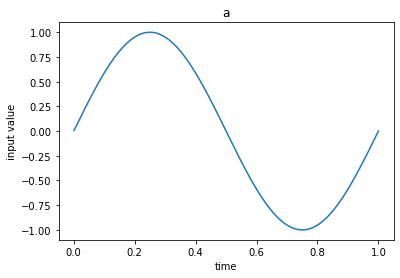

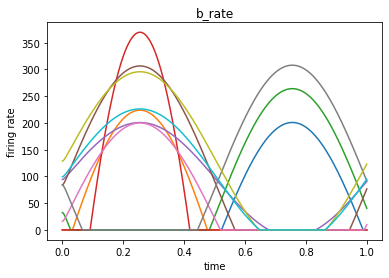

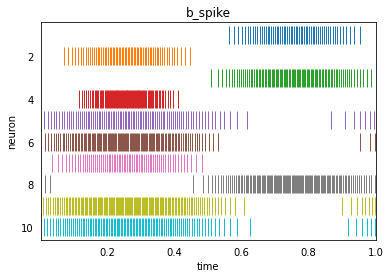

In [6]:
with nengo.Network() as net:
    # our input node will output a sine wave with a period of 1 second
    a = nengo.Node(lambda t: np.sin(2 * np.pi * t))
    
    # we'll create one ensemble with rate neurons
    b_rate = nengo.Ensemble(
        10, 1, neuron_type=nengo.RectifiedLinear(), seed=2)
    nengo.Connection(a, b_rate)
    
    # and another ensemble with spiking neurons
    b_spike = nengo.Ensemble(
        10, 1, neuron_type=nengo.SpikingRectifiedLinear(), seed=2)
    nengo.Connection(a, b_spike)
    
    p_a = nengo.Probe(a)
    p_rate = nengo.Probe(b_rate.neurons)
    p_spike = nengo.Probe(b_spike.neurons)
    
with nengo_dl.Simulator(net) as sim:
    # simulate the model for 1 second
    # note that we are not providing any input data, so input 
    # data will be automatically generated based on the sine function
    # in the Node definition.
    sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[p_a])
plt.xlabel("time")
plt.ylabel("input value")
plt.title("a")
    
plt.figure()
plt.plot(sim.trange(), sim.data[p_rate])
plt.xlabel("time")
plt.ylabel("firing rate")
plt.title("b_rate")

plt.figure()
rasterplot(sim.trange(), sim.data[p_spike])
plt.xlabel("time")
plt.ylabel("neuron")
plt.title("b_spike");

Each neuron responds to the input signal differently due to the random parameterization in the network (e.g. connection weights and biases).  We have matched the parameterization in the rate and spiking ensembles so that it is easier to see the parallels.

Note that the same information is being represented in the two ensembles.  For example, when the second neuron (orange) is outputting a high continuous value (in the second graph), the corresponding spiking neuron is outputting more discrete spikes (orange lines in the third graph).

We can see the parallels more clearly if we introduce another Nengo feature, synaptic filters.  This is inspired by a biological feature where discrete spikes induce a continuous electrical waveform in the receiving neuron, at the synapse (the point where the two neurons connect).  But computationally we can think of this simply as applying a filter to the spiking signal.

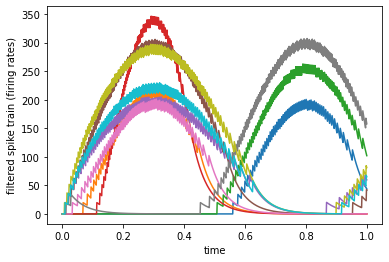

In [7]:
# nengo uses a linear lowpass filter by default
filt = nengo.Lowpass(tau=0.05)

# apply filter to ensemble output spikes
filtered_spikes = filt.filt(sim.data[p_spike])

plt.figure()
plt.plot(sim.trange(), filtered_spikes)
plt.xlabel("time")
plt.ylabel("filtered spike train (firing rates)");

We can see how the spike trains, when viewed through a synaptic filter, approximate the continuous rate values in the second graph above.  

In this example we have computed the filtered signal manually for demonstration purposes, but in a typical Nengo model these synaptic filters are applied throughout the model, on the `Connection` objects.  For example, the above filtering would be equivalent to `nengo.Connection(b_spike.neurons, x, synapse=0.05)` (from the perspective of a hypothetical downstream object `x`).

This is a helpful duality to keep in mind when coming to neuromorphic modelling and Nengo from a standard deep network background.  Although spiking neurons seem like a radically different paradigm, they can compute and communicate the same information as their rate counterparts.  But note that this only makes sense when we think of the network temporally (neurons spiking and being filtered over time).

There are many other neuron types built into Nengo (see [the documentation](https://www.nengo.ai/nengo/frontend-api.html#neuron-types) for a complete list).  These neuron models have various different behaviours, and managing their parameterization and simulation is an important part of Nengo's design.

## Inserting TensorFlow code

The goal of NengoDL is not to replace TensorFlow or Nengo, but to allow them to smoothly work together.  Thus one important feature is the ability to write TensorFlow code directly, and insert it into a Nengo network.  This allows us to use whichever framework is best suited for different parts of a model.

This functionality is accessed through the `nengo_dl.TensorNode` class.  This allows us to wrap TensorFlow code in a Nengo object, so that it can easily communicate with the rest of a Nengo model.  The TensorFlow code is written in a function that takes `tf.Tensors` as input, applies the desired manipulations through TensorFlow operations, and returns a `tf.Tensor`.  We then pass that function to the TensorNode.

For simple cases we can use `nengo_dl.Layer`.  This is a simplified interface for constructing `TensorNodes` that mimics the Keras functional API.  For example, suppose we want to apply batch normalization to the output of one of the Nengo ensembles.  There is no built-in way to do batch normalization in Nengo, so we can instead turn to TensorFlow for this part of the model.

In [8]:
with net:
    batch_norm = nengo_dl.Layer(
        tf.keras.layers.BatchNormalization(momentum=0.9))(b_rate.neurons)
    p_batch_norm = nengo.Probe(batch_norm)

This is essentially equivalent to the Keras layer `tf.keras.layers.BatchNormalization`, except it works with Nengo objects.  For example, `b_rate` is a `nengo.Ensemble` in this case, and we can add Probes or Connections to `batch_norm` in the same way as any other Nengo object.

Using `nengo_dl.Layer` is simply a shortcut for creating a `TensorNode` and `Connection`; the above is equivalent to

In [9]:
with net:
    batch_norm = nengo_dl.TensorNode(
        tf.keras.layers.BatchNormalization(momentum=0.9), 
        shape_in=(10,), pass_time=False)
    nengo.Connection(b_rate.neurons, batch_norm, synapse=None)
    p_batch_norm = nengo.Probe(batch_norm)

In general, we can use any function (a built in TensorFlow function or one we write ourselves) in a TensorNode.  It can accept two parameters, `t` and `x`, where `t` is the current simulation time and `x` is the value of any Connections incoming to the TensorNode.  We can use `pass_time=False` if we don't need the time input. `x` will have shape `(minibatch_size,) + shape_in`, where `shape_in` is the parameter passed to the `TensorNode` (or inferred from the input object in the case of `nengo_dl.Layer`).  The `TensorNode`/`Layer` function should return a `tf.Tensor` with shape `(minibatch_size,) + shape_out`, where `shape_out` is the output dimensionality of the node (dependent on the manipulations applied to the inputs `x`).  We could explicitly specify `shape_out=(10,)` in the above example, or if we don't specify the output shape it will be determined automatically by calling the node function with placeholder inputs.

Here is a simple network to illustrate a TensorNode's input and output:

In [10]:
with nengo.Network() as net:
    # node to provide an input value for the TensorNode
    a = nengo.Node([0.5, -0.1]) 
    
    # a TensorNode function to illustrate i/o
    def tensor_func(t, x):
        # print out the value of inputs t and x
        print_t = tf.print("t:", t)
        with tf.control_dependencies([print_t]):
            print_x = tf.print("x:", x)
        
        # output t + x
        with tf.control_dependencies([print_x]):
            return tf.add(t, x)
        
    # create the TensorNode
    b = nengo_dl.TensorNode(tensor_func, shape_in=(2,), 
                            shape_out=(2,))
    nengo.Connection(a, b, synapse=None)
    
    p = nengo.Probe(b)
    
with nengo_dl.Simulator(net) as sim:
    print("TensorNode input:")
    data = sim.predict(n_steps=10)
    print("TensorNode output:")
    print(data[p])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

TensorNode input:
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

t: 0.001


x: [[0.5 -0.1]]


t: 0.002


x: [[0.5 -0.1]]


t: 0.003


x: [[0.5 -0.1]]


t: 0.004


x: [[0.5 -0.1]]


t: 0.00500000035


x: [[0.5 -0.1]]


t: 0.006


x: [[0.5 -0.1]]


t: 0.007


x: [[0.5 -0.1]]


t: 0.008


x: [[0.5 -0.1]]


t: 0.00900000054


x: [[0.5 -0.1]]


t: 0.0100000007


x: [[0.5 -0.1]]


TensorNode output:
[[[ 0.501 -0.099]
  [ 0.502 -0.098]
  [ 0.503 -0.097]
  [ 0.504 -0.096]
  [ 0.505 -0.095]
  [ 0.506 -0.094]
  [ 0.507 -0.093]
  [ 0.508 -0.092]
  [ 0.509 -0.091]
  [ 0.51  -0.09 ]]]


We can see, as we expect, that the input tensor `t` is reflecting the current simulation time over the 10 timesteps we executed, and `x` contains the value of the input Node that we connected to the TensorNode.  And we can see in the probe data that the TensorNode is outputting the operation we defined in TensorFlow (`tf.add(t, x)`).

We can define more complicated TensorNodes by implementing a custom Keras Layer.  This can be useful, for example, if the TensorNode requires internal parameters (which should be created in the Keras Layer's `build` function).

Here is a simple TensorNode that illustrates the usage of a custom Layer:

In [11]:
with nengo.Network() as net:
    class MyLayer(tf.keras.layers.Layer):
        def build(self, input_shapes):
            self.w = self.add_weight(shape=(1, 1))
        
        def call(self, inputs):
            return inputs * self.w
            
    a = nengo_dl.TensorNode(MyLayer(), shape_in=(1,), 
                            pass_time=False)

More details on TensorNode usage can be found in [the user guide](https://www.nengo.ai/nengo-dl/tensor-node.html).

## Deep learning parameter optimization

NengoDL allows model parameters to be optimized via TensorFlow optimization algorithms, through the `Simulator.fit` function.  Returning to the autoencoder examples from the beginning of this tutorial, we'll optimize those networks to encode MNIST digits.

In [12]:
# download MNIST dataset
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()
# flatten images
train_data = train_data.reshape((train_data.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))

n_epochs = 2

In TensorFlow the training would be done something like:

Epoch 1/2


   1/1875 [..............................] - ETA: 0s - loss: 6436.1597

  34/1875 [..............................] - ETA: 2s - loss: 4252.0156

  64/1875 [>.............................] - ETA: 2s - loss: 3706.5466

  98/1875 [>.............................] - ETA: 2s - loss: 3323.0042

 132/1875 [=>............................] - ETA: 2s - loss: 3043.9736

 165/1875 [=>............................] - ETA: 2s - loss: 2843.7158

 197/1875 [==>...........................] - ETA: 2s - loss: 2684.0149



 231/1875 [==>...........................] - ETA: 2s - loss: 2549.2380

 265/1875 [===>..........................] - ETA: 2s - loss: 2439.3901

 294/1875 [===>..........................] - ETA: 2s - loss: 2357.8396

 323/1875 [====>.........................] - ETA: 2s - loss: 2288.9680

 357/1875 [====>.........................] - ETA: 2s - loss: 2216.4177

 391/1875 [=====>........................] - ETA: 2s - loss: 2152.6846

 423/1875 [=====>........................] - ETA: 2s - loss: 2099.8496

 456/1875 [======>.......................] - ETA: 2s - loss: 2049.2222

 490/1875 [======>.......................] - ETA: 2s - loss: 2001.5698

 524/1875 [=======>......................] - ETA: 2s - loss: 1958.7629

 556/1875 [=======>......................] - ETA: 2s - loss: 1923.3427

 590/1875 [========>.....................] - ETA: 1s - loss: 1887.3529

 624/1875 [========>.....................] - ETA: 1s - loss: 1855.9409

 657/1875 [=========>....................] - ETA: 1s - loss: 1827.0651

 688/1875 [==========>...................] - ETA: 1s - loss: 1800.6492

 722/1875 [==========>...................] - ETA: 1s - loss: 1774.6250

 755/1875 [===========>..................] - ETA: 1s - loss: 1750.3551

 789/1875 [===========>..................] - ETA: 1s - loss: 1728.9282

 822/1875 [============>.................] - ETA: 1s - loss: 1707.4667

 853/1875 [============>.................] - ETA: 1s - loss: 1689.6244

 885/1875 [=============>................] - ETA: 1s - loss: 1671.4200

 918/1875 [=============>................] - ETA: 1s - loss: 1654.2915

 951/1875 [==============>...............] - ETA: 1s - loss: 1638.2399

 984/1875 [==============>...............] - ETA: 1s - loss: 1622.2777

1017/1875 [===============>..............] - ETA: 1s - loss: 1608.8716

1049/1875 [===============>..............] - ETA: 1s - loss: 1594.4126

1083/1875 [================>.............] - ETA: 1s - loss: 1579.9895

1117/1875 [================>.............] - ETA: 1s - loss: 1567.5927

1147/1875 [=================>............] - ETA: 1s - loss: 1556.1915

1180/1875 [=================>............] - ETA: 1s - loss: 1544.8578

1214/1875 [==================>...........] - ETA: 1s - loss: 1532.7235

1248/1875 [==================>...........] - ETA: 0s - loss: 1520.8204

1283/1875 [===================>..........] - ETA: 0s - loss: 1509.4843

1316/1875 [====================>.........] - ETA: 0s - loss: 1499.1406

1349/1875 [====================>.........] - ETA: 0s - loss: 1490.3301

1381/1875 [=====================>........] - ETA: 0s - loss: 1481.2058

1413/1875 [=====================>........] - ETA: 0s - loss: 1472.3011

1443/1875 [======================>.......] - ETA: 0s - loss: 1464.0326

1475/1875 [======================>.......] - ETA: 0s - loss: 1455.6788

1506/1875 [=======================>......] - ETA: 0s - loss: 1447.8650

1537/1875 [=======================>......] - ETA: 0s - loss: 1440.5050

1564/1875 [========================>.....] - ETA: 0s - loss: 1434.4545

1591/1875 [========================>.....] - ETA: 0s - loss: 1429.0757

1621/1875 [========================>.....] - ETA: 0s - loss: 1422.2405

1649/1875 [=========================>....] - ETA: 0s - loss: 1415.4606

1679/1875 [=========================>....] - ETA: 0s - loss: 1409.8190

1708/1875 [==========================>...] - ETA: 0s - loss: 1404.1050

1737/1875 [==========================>...] - ETA: 0s - loss: 1398.3253

1768/1875 [===========================>..] - ETA: 0s - loss: 1392.6796

1798/1875 [===========================>..] - ETA: 0s - loss: 1387.5413

1829/1875 [============================>.] - ETA: 0s - loss: 1381.6024

1860/1875 [============================>.] - ETA: 0s - loss: 1376.0466

1875/1875 [==============================] - 3s 2ms/step - loss: 1373.1230


Epoch 2/2
   1/1875 [..............................] - ETA: 0s - loss: 1073.2595

  33/1875 [..............................] - ETA: 2s - loss: 1040.7648

  62/1875 [..............................] - ETA: 2s - loss: 1049.6046

  92/1875 [>.............................] - ETA: 2s - loss: 1043.6611

 124/1875 [>.............................] - ETA: 2s - loss: 1041.2225

 155/1875 [=>............................] - ETA: 2s - loss: 1036.6102

 187/1875 [=>............................] - ETA: 2s - loss: 1034.0042

 217/1875 [==>...........................] - ETA: 2s - loss: 1033.5707

 248/1875 [==>...........................] - ETA: 2s - loss: 1031.9323

 279/1875 [===>..........................] - ETA: 2s - loss: 1033.0895

 308/1875 [===>..........................] - ETA: 2s - loss: 1035.3041

 337/1875 [====>.........................] - ETA: 2s - loss: 1034.0184

 367/1875 [====>.........................] - ETA: 2s - loss: 1034.9314

 398/1875 [=====>........................] - ETA: 2s - loss: 1031.8591

 430/1875 [=====>........................] - ETA: 2s - loss: 1030.5919

 460/1875 [======>.......................] - ETA: 2s - loss: 1033.1110

 490/1875 [======>.......................] - ETA: 2s - loss: 1033.1665

 521/1875 [=======>......................] - ETA: 2s - loss: 1031.9612

 552/1875 [=======>......................] - ETA: 2s - loss: 1032.8301

 583/1875 [========>.....................] - ETA: 2s - loss: 1032.4762

 612/1875 [========>.....................] - ETA: 2s - loss: 1031.6786

 643/1875 [=========>....................] - ETA: 2s - loss: 1030.0718

 671/1875 [=========>....................] - ETA: 2s - loss: 1030.4050

 701/1875 [==========>...................] - ETA: 1s - loss: 1029.0756

 733/1875 [==========>...................] - ETA: 1s - loss: 1028.0431

 760/1875 [===========>..................] - ETA: 1s - loss: 1026.5585

 791/1875 [===========>..................] - ETA: 1s - loss: 1025.2197

 821/1875 [============>.................] - ETA: 1s - loss: 1025.3213

 851/1875 [============>.................] - ETA: 1s - loss: 1023.3406

 884/1875 [=============>................] - ETA: 1s - loss: 1024.0425

 915/1875 [=============>................] - ETA: 1s - loss: 1023.6444

 946/1875 [==============>...............] - ETA: 1s - loss: 1022.3018

 975/1875 [==============>...............] - ETA: 1s - loss: 1021.1367

1006/1875 [===============>..............] - ETA: 1s - loss: 1020.1662

1038/1875 [===============>..............] - ETA: 1s - loss: 1019.8834

1069/1875 [================>.............] - ETA: 1s - loss: 1018.8730

1098/1875 [================>.............] - ETA: 1s - loss: 1018.5817

1128/1875 [=================>............] - ETA: 1s - loss: 1018.8753

1159/1875 [=================>............] - ETA: 1s - loss: 1018.3840

1192/1875 [==================>...........] - ETA: 1s - loss: 1017.3727

1222/1875 [==================>...........] - ETA: 1s - loss: 1017.0594

1252/1875 [===================>..........] - ETA: 1s - loss: 1016.1178

1283/1875 [===================>..........] - ETA: 0s - loss: 1016.2994

1314/1875 [====================>.........] - ETA: 0s - loss: 1015.4719

1346/1875 [====================>.........] - ETA: 0s - loss: 1014.7505

1378/1875 [=====================>........] - ETA: 0s - loss: 1014.6741

1408/1875 [=====================>........] - ETA: 0s - loss: 1013.4421

1439/1875 [======================>.......] - ETA: 0s - loss: 1013.0009

1471/1875 [======================>.......] - ETA: 0s - loss: 1012.2533

1500/1875 [=======================>......] - ETA: 0s - loss: 1012.2931

1531/1875 [=======================>......] - ETA: 0s - loss: 1011.8370

1562/1875 [=======================>......] - ETA: 0s - loss: 1011.2017

1591/1875 [========================>.....] - ETA: 0s - loss: 1010.7365

1618/1875 [========================>.....] - ETA: 0s - loss: 1010.1757

1646/1875 [=========================>....] - ETA: 0s - loss: 1009.8575

1677/1875 [=========================>....] - ETA: 0s - loss: 1008.8269

1710/1875 [==========================>...] - ETA: 0s - loss: 1008.5639

1741/1875 [==========================>...] - ETA: 0s - loss: 1007.2246

1769/1875 [===========================>..] - ETA: 0s - loss: 1007.1683

1798/1875 [===========================>..] - ETA: 0s - loss: 1006.8030

1830/1875 [============================>.] - ETA: 0s - loss: 1006.3951

1864/1875 [============================>.] - ETA: 0s - loss: 1006.2797

1875/1875 [==============================] - 3s 2ms/step - loss: 1006.2230


  1/313 [..............................] - ETA: 0s - loss: 881.0750

 48/313 [===>..........................] - ETA: 0s - loss: 907.8418

 89/313 [=======>......................] - ETA: 0s - loss: 910.1564

129/313 [===========>..................] - ETA: 0s - loss: 910.6723

169/313 [===============>..............] - ETA: 0s - loss: 910.2363

209/313 [===================>..........] - ETA: 0s - loss: 929.7184

255/313 [=======================>......] - ETA: 0s - loss: 944.7942

296/313 [===========================>..] - ETA: 0s - loss: 959.8728

313/313 [==============================] - 0s 1ms/step - loss: 957.5905


Test error: 957.5905151367188


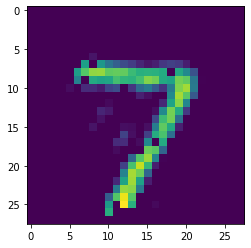

In [13]:
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
model.compile(optimizer=tf.optimizers.RMSprop(1e-3), 
              loss=tf.losses.mse)

# run training loop
model.fit(train_data, train_data, epochs=n_epochs)

# evaluate performance on test set
print("Test error:", model.evaluate(test_data, test_data))

# display example output
output = model.predict(test_data[[0]])
plt.figure()
plt.imshow(output[0].reshape((28, 28)));

Before running the same training in NengoDL, we'll change the Nengo model parameters to more closely match the TensorFlow network (we omitted these details in the original presentation to keep things simple).

In [14]:
# set initial neuron gains to 1 and biases to 0
for ens in auto_net.all_ensembles:
    ens.gain = nengo.dists.Choice([1])
    ens.bias = nengo.dists.Choice([0])

# disable synaptic filtering on all connections
for conn in auto_net.all_connections:
    conn.synapse = None

We also need to modify the data slightly.  As mentioned above, NengoDL simulations are essentially temporal, so data is described over time (indicating what the inputs/targets should be on each simulation timestep).  So instead of the data having shape `(batch_size, n)`, it will have shape `(batch_size, n_steps, n)`.  In this case we'll just be training for a single timestep, but we still need to add that extra axis with length 1.

In [15]:
train_data = train_data[:, None, :]
test_data = test_data[:, None, :]

Now we can run the NengoDL equivalent of the above TensorFlow training:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (40%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/2
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (30%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (30%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

   1/1200 [..............................] - ETA: 0s - loss: 7098.9419 - probe_loss: 7098.9419

  14/1200 [..............................] - ETA: 4s - loss: 4953.1401 - probe_loss: 4953.1401

  26/1200 [..............................] - ETA: 4s - loss: 4355.5864 - probe_loss: 4355.5864

  37/1200 [..............................] - ETA: 4s - loss: 4005.1111 - probe_loss: 4005.1111

  49/1200 [>.............................] - ETA: 4s - loss: 3715.6028 - probe_loss: 3715.6028

  62/1200 [>.............................] - ETA: 4s - loss: 3474.6880 - probe_loss: 3474.6880

  76/1200 [>.............................] - ETA: 4s - loss: 3279.9626 - probe_loss: 3279.9626

  89/1200 [=>............................] - ETA: 4s - loss: 3139.0381 - probe_loss: 3139.0381

 101/1200 [=>............................] - ETA: 4s - loss: 3019.3652 - probe_loss: 3019.3652

 114/1200 [=>............................] - ETA: 4s - loss: 2908.4170 - probe_loss: 2908.4170

 126/1200 [==>...........................] - ETA: 4s - loss: 2820.3225 - probe_loss: 2820.3225

 140/1200 [==>...........................] - ETA: 4s - loss: 2735.2512 - probe_loss: 2735.2512

 152/1200 [==>...........................] - ETA: 4s - loss: 2665.8191 - probe_loss: 2665.8191

 164/1200 [===>..........................] - ETA: 4s - loss: 2605.0527 - probe_loss: 2605.0527

 176/1200 [===>..........................] - ETA: 4s - loss: 2546.1096 - probe_loss: 2546.1096

 189/1200 [===>..........................] - ETA: 4s - loss: 2490.2949 - probe_loss: 2490.2949

 202/1200 [====>.........................] - ETA: 4s - loss: 2435.8276 - probe_loss: 2435.8276

 215/1200 [====>.........................] - ETA: 4s - loss: 2385.1265 - probe_loss: 2385.1265

 226/1200 [====>.........................] - ETA: 4s - loss: 2346.5273 - probe_loss: 2346.5273

 239/1200 [====>.........................] - ETA: 3s - loss: 2304.3420 - probe_loss: 2304.3420

 252/1200 [=====>........................] - ETA: 3s - loss: 2261.6458 - probe_loss: 2261.6458

 265/1200 [=====>........................] - ETA: 3s - loss: 2224.7979 - probe_loss: 2224.7979

 277/1200 [=====>........................] - ETA: 3s - loss: 2191.1228 - probe_loss: 2191.1228

 289/1200 [======>.......................] - ETA: 3s - loss: 2157.0750 - probe_loss: 2157.0750

 302/1200 [======>.......................] - ETA: 3s - loss: 2127.0752 - probe_loss: 2127.0752

 315/1200 [======>.......................] - ETA: 3s - loss: 2098.3804 - probe_loss: 2098.3804

 328/1200 [=======>......................] - ETA: 3s - loss: 2068.9504 - probe_loss: 2068.9504

 340/1200 [=======>......................] - ETA: 3s - loss: 2041.6847 - probe_loss: 2041.6847

 353/1200 [=======>......................] - ETA: 3s - loss: 2015.1224 - probe_loss: 2015.1224

 365/1200 [========>.....................] - ETA: 3s - loss: 1990.5514 - probe_loss: 1990.5514

 377/1200 [========>.....................] - ETA: 3s - loss: 1969.6290 - probe_loss: 1969.6290

 389/1200 [========>.....................] - ETA: 3s - loss: 1949.0649 - probe_loss: 1949.0649

 402/1200 [=========>....................] - ETA: 3s - loss: 1926.9636 - probe_loss: 1926.9636

 415/1200 [=========>....................] - ETA: 3s - loss: 1906.5145 - probe_loss: 1906.5145

 427/1200 [=========>....................] - ETA: 3s - loss: 1888.5688 - probe_loss: 1888.5688

 440/1200 [==========>...................] - ETA: 3s - loss: 1868.9941 - probe_loss: 1868.9941

 453/1200 [==========>...................] - ETA: 3s - loss: 1851.5580 - probe_loss: 1851.5580

 465/1200 [==========>...................] - ETA: 3s - loss: 1834.2748 - probe_loss: 1834.2748

 478/1200 [==========>...................] - ETA: 2s - loss: 1817.2865 - probe_loss: 1817.2865

 488/1200 [===========>..................] - ETA: 2s - loss: 1804.4860 - probe_loss: 1804.4860

 501/1200 [===========>..................] - ETA: 2s - loss: 1788.7010 - probe_loss: 1788.7010

 514/1200 [===========>..................] - ETA: 2s - loss: 1772.4436 - probe_loss: 1772.4436

 526/1200 [============>.................] - ETA: 2s - loss: 1760.0219 - probe_loss: 1760.0219

 538/1200 [============>.................] - ETA: 2s - loss: 1747.3247 - probe_loss: 1747.3247

 550/1200 [============>.................] - ETA: 2s - loss: 1735.5768 - probe_loss: 1735.5768

 562/1200 [=============>................] - ETA: 2s - loss: 1723.6805 - probe_loss: 1723.6805

 575/1200 [=============>................] - ETA: 2s - loss: 1711.5275 - probe_loss: 1711.5275

 588/1200 [=============>................] - ETA: 2s - loss: 1697.6378 - probe_loss: 1697.6378

 601/1200 [==============>...............] - ETA: 2s - loss: 1685.7433 - probe_loss: 1685.7433

 614/1200 [==============>...............] - ETA: 2s - loss: 1674.2048 - probe_loss: 1674.2048

 627/1200 [==============>...............] - ETA: 2s - loss: 1664.1635 - probe_loss: 1664.1635

 639/1200 [==============>...............] - ETA: 2s - loss: 1653.9474 - probe_loss: 1653.9474

 652/1200 [===============>..............] - ETA: 2s - loss: 1643.6721 - probe_loss: 1643.6721

 665/1200 [===============>..............] - ETA: 2s - loss: 1633.2339 - probe_loss: 1633.2339

 677/1200 [===============>..............] - ETA: 2s - loss: 1624.0559 - probe_loss: 1624.0559

 689/1200 [================>.............] - ETA: 2s - loss: 1615.9082 - probe_loss: 1615.9082

 702/1200 [================>.............] - ETA: 2s - loss: 1606.5551 - probe_loss: 1606.5551

 715/1200 [================>.............] - ETA: 2s - loss: 1597.0684 - probe_loss: 1597.0684

 729/1200 [=================>............] - ETA: 1s - loss: 1587.2411 - probe_loss: 1587.2411

 742/1200 [=================>............] - ETA: 1s - loss: 1578.3295 - probe_loss: 1578.3295

 755/1200 [=================>............] - ETA: 1s - loss: 1569.7930 - probe_loss: 1569.7930

 767/1200 [==================>...........] - ETA: 1s - loss: 1562.9952 - probe_loss: 1562.9952

 781/1200 [==================>...........] - ETA: 1s - loss: 1554.9901 - probe_loss: 1554.9901

 794/1200 [==================>...........] - ETA: 1s - loss: 1547.2839 - probe_loss: 1547.2839

 806/1200 [===================>..........] - ETA: 1s - loss: 1540.1810 - probe_loss: 1540.1810

 818/1200 [===================>..........] - ETA: 1s - loss: 1533.9933 - probe_loss: 1533.9933

 830/1200 [===================>..........] - ETA: 1s - loss: 1527.3914 - probe_loss: 1527.3914

 842/1200 [====================>.........] - ETA: 1s - loss: 1520.8872 - probe_loss: 1520.8872

 854/1200 [====================>.........] - ETA: 1s - loss: 1514.5481 - probe_loss: 1514.5481

 867/1200 [====================>.........] - ETA: 1s - loss: 1507.6218 - probe_loss: 1507.6218

 879/1200 [====================>.........] - ETA: 1s - loss: 1501.1091 - probe_loss: 1501.1091

 892/1200 [=====================>........] - ETA: 1s - loss: 1494.6323 - probe_loss: 1494.6323

 905/1200 [=====================>........] - ETA: 1s - loss: 1487.7914 - probe_loss: 1487.7914

 918/1200 [=====================>........] - ETA: 1s - loss: 1481.7897 - probe_loss: 1481.7897

 928/1200 [======================>.......] - ETA: 1s - loss: 1477.1527 - probe_loss: 1477.1527

 940/1200 [======================>.......] - ETA: 1s - loss: 1471.3246 - probe_loss: 1471.3246

 951/1200 [======================>.......] - ETA: 1s - loss: 1466.6158 - probe_loss: 1466.6158

 964/1200 [=======================>......] - ETA: 0s - loss: 1460.9253 - probe_loss: 1460.9253

 977/1200 [=======================>......] - ETA: 0s - loss: 1455.7086 - probe_loss: 1455.7086

 990/1200 [=======================>......] - ETA: 0s - loss: 1449.9991 - probe_loss: 1449.9991

1003/1200 [========================>.....] - ETA: 0s - loss: 1444.4014 - probe_loss: 1444.4014

1017/1200 [========================>.....] - ETA: 0s - loss: 1438.3472 - probe_loss: 1438.3472

1030/1200 [========================>.....] - ETA: 0s - loss: 1432.8539 - probe_loss: 1432.8539

1044/1200 [=========================>....] - ETA: 0s - loss: 1427.2737 - probe_loss: 1427.2737

1056/1200 [=========================>....] - ETA: 0s - loss: 1422.4409 - probe_loss: 1422.4409

1068/1200 [=========================>....] - ETA: 0s - loss: 1417.5911 - probe_loss: 1417.5911

1080/1200 [==========================>...] - ETA: 0s - loss: 1412.9944 - probe_loss: 1412.9944

1093/1200 [==========================>...] - ETA: 0s - loss: 1408.3888 - probe_loss: 1408.3888

1106/1200 [==========================>...] - ETA: 0s - loss: 1403.8976 - probe_loss: 1403.8976

1118/1200 [==========================>...] - ETA: 0s - loss: 1399.4188 - probe_loss: 1399.4188

1130/1200 [===========================>..] - ETA: 0s - loss: 1395.1887 - probe_loss: 1395.1887

1143/1200 [===========================>..] - ETA: 0s - loss: 1390.7102 - probe_loss: 1390.7102

1156/1200 [===========================>..] - ETA: 0s - loss: 1386.5459 - probe_loss: 1386.5459

1169/1200 [============================>.] - ETA: 0s - loss: 1382.6073 - probe_loss: 1382.6073

1181/1200 [============================>.] - ETA: 0s - loss: 1378.3175 - probe_loss: 1378.3175

1193/1200 [============================>.] - ETA: 0s - loss: 1374.6085 - probe_loss: 1374.6085

1200/1200 [==============================] - 5s 4ms/step - loss: 1372.2705 - probe_loss: 1372.2705


Epoch 2/2
   1/1200 [..............................] - ETA: 0s - loss: 912.5593 - probe_loss: 912.5593

  15/1200 [..............................] - ETA: 4s - loss: 1001.3990 - probe_loss: 1001.3990

  28/1200 [..............................] - ETA: 4s - loss: 1004.6750 - probe_loss: 1004.6750

  39/1200 [..............................] - ETA: 4s - loss: 1001.7227 - probe_loss: 1001.7227

  51/1200 [>.............................] - ETA: 4s - loss: 997.7959 - probe_loss: 997.7959  

  64/1200 [>.............................] - ETA: 4s - loss: 987.8617 - probe_loss: 987.8617

  77/1200 [>.............................] - ETA: 4s - loss: 987.4221 - probe_loss: 987.4221

  89/1200 [=>............................] - ETA: 4s - loss: 984.5632 - probe_loss: 984.5632

 101/1200 [=>............................] - ETA: 4s - loss: 983.3140 - probe_loss: 983.3140

 114/1200 [=>............................] - ETA: 4s - loss: 983.4846 - probe_loss: 983.4846

 128/1200 [==>...........................] - ETA: 4s - loss: 984.4553 - probe_loss: 984.4553

 140/1200 [==>...........................] - ETA: 4s - loss: 985.2109 - probe_loss: 985.2109

 152/1200 [==>...........................] - ETA: 4s - loss: 982.6125 - probe_loss: 982.6125

 164/1200 [===>..........................] - ETA: 4s - loss: 978.6614 - probe_loss: 978.6614

 178/1200 [===>..........................] - ETA: 4s - loss: 977.9489 - probe_loss: 977.9489

 190/1200 [===>..........................] - ETA: 4s - loss: 978.7979 - probe_loss: 978.7979

 203/1200 [====>.........................] - ETA: 4s - loss: 978.5803 - probe_loss: 978.5803

 215/1200 [====>.........................] - ETA: 4s - loss: 977.8405 - probe_loss: 977.8405

 227/1200 [====>.........................] - ETA: 4s - loss: 977.0819 - probe_loss: 977.0819

 240/1200 [=====>........................] - ETA: 3s - loss: 975.0125 - probe_loss: 975.0125

 252/1200 [=====>........................] - ETA: 3s - loss: 976.7167 - probe_loss: 976.7167

 265/1200 [=====>........................] - ETA: 3s - loss: 976.8750 - probe_loss: 976.8750

 278/1200 [=====>........................] - ETA: 3s - loss: 977.9807 - probe_loss: 977.9807

 291/1200 [======>.......................] - ETA: 3s - loss: 977.1931 - probe_loss: 977.1931

 304/1200 [======>.......................] - ETA: 3s - loss: 978.0283 - probe_loss: 978.0283

 313/1200 [======>.......................] - ETA: 3s - loss: 976.9873 - probe_loss: 976.9873

 325/1200 [=======>......................] - ETA: 3s - loss: 977.2981 - probe_loss: 977.2981

 338/1200 [=======>......................] - ETA: 3s - loss: 975.3700 - probe_loss: 975.3700

 351/1200 [=======>......................] - ETA: 3s - loss: 974.5503 - probe_loss: 974.5503

 364/1200 [========>.....................] - ETA: 3s - loss: 971.8590 - probe_loss: 971.8590

 376/1200 [========>.....................] - ETA: 3s - loss: 971.7318 - probe_loss: 971.7318

 389/1200 [========>.....................] - ETA: 3s - loss: 970.4561 - probe_loss: 970.4561

 401/1200 [=========>....................] - ETA: 3s - loss: 969.8264 - probe_loss: 969.8264

 413/1200 [=========>....................] - ETA: 3s - loss: 969.7468 - probe_loss: 969.7468

 425/1200 [=========>....................] - ETA: 3s - loss: 968.1214 - probe_loss: 968.1214

 437/1200 [=========>....................] - ETA: 3s - loss: 967.6328 - probe_loss: 967.6328

 450/1200 [==========>...................] - ETA: 3s - loss: 967.8375 - probe_loss: 967.8375

 463/1200 [==========>...................] - ETA: 3s - loss: 967.4962 - probe_loss: 967.4962

 475/1200 [==========>...................] - ETA: 3s - loss: 967.3381 - probe_loss: 967.3381

 487/1200 [===========>..................] - ETA: 2s - loss: 967.2394 - probe_loss: 967.2394

 499/1200 [===========>..................] - ETA: 2s - loss: 967.3044 - probe_loss: 967.3044

 512/1200 [===========>..................] - ETA: 2s - loss: 966.3318 - probe_loss: 966.3318

 524/1200 [============>.................] - ETA: 2s - loss: 965.7144 - probe_loss: 965.7144

 536/1200 [============>.................] - ETA: 2s - loss: 964.5365 - probe_loss: 964.5365

 548/1200 [============>.................] - ETA: 2s - loss: 964.6837 - probe_loss: 964.6837

 561/1200 [=============>................] - ETA: 2s - loss: 964.0790 - probe_loss: 964.0790

 572/1200 [=============>................] - ETA: 2s - loss: 963.3723 - probe_loss: 963.3723

 584/1200 [=============>................] - ETA: 2s - loss: 962.6901 - probe_loss: 962.6901

 595/1200 [=============>................] - ETA: 2s - loss: 961.8417 - probe_loss: 961.8417

 606/1200 [==============>...............] - ETA: 2s - loss: 960.6276 - probe_loss: 960.6276

 619/1200 [==============>...............] - ETA: 2s - loss: 960.3886 - probe_loss: 960.3886

 632/1200 [==============>...............] - ETA: 2s - loss: 960.1342 - probe_loss: 960.1342

 644/1200 [===============>..............] - ETA: 2s - loss: 959.8619 - probe_loss: 959.8619

 655/1200 [===============>..............] - ETA: 2s - loss: 959.4257 - probe_loss: 959.4257

 668/1200 [===============>..............] - ETA: 2s - loss: 958.2370 - probe_loss: 958.2370

 682/1200 [================>.............] - ETA: 2s - loss: 957.6303 - probe_loss: 957.6303

 694/1200 [================>.............] - ETA: 2s - loss: 956.7360 - probe_loss: 956.7360

 706/1200 [================>.............] - ETA: 2s - loss: 957.0364 - probe_loss: 957.0364

 718/1200 [================>.............] - ETA: 2s - loss: 956.7385 - probe_loss: 956.7385

 731/1200 [=================>............] - ETA: 1s - loss: 956.6046 - probe_loss: 956.6046

 744/1200 [=================>............] - ETA: 1s - loss: 956.0368 - probe_loss: 956.0368

 756/1200 [=================>............] - ETA: 1s - loss: 955.4858 - probe_loss: 955.4858

 768/1200 [==================>...........] - ETA: 1s - loss: 955.2277 - probe_loss: 955.2277

 782/1200 [==================>...........] - ETA: 1s - loss: 954.9352 - probe_loss: 954.9352

 796/1200 [==================>...........] - ETA: 1s - loss: 954.4572 - probe_loss: 954.4572

 809/1200 [===================>..........] - ETA: 1s - loss: 953.5764 - probe_loss: 953.5764

 821/1200 [===================>..........] - ETA: 1s - loss: 953.1024 - probe_loss: 953.1024

 834/1200 [===================>..........] - ETA: 1s - loss: 952.7414 - probe_loss: 952.7414

 847/1200 [====================>.........] - ETA: 1s - loss: 952.0569 - probe_loss: 952.0569

 860/1200 [====================>.........] - ETA: 1s - loss: 951.8295 - probe_loss: 951.8295

 873/1200 [====================>.........] - ETA: 1s - loss: 950.6916 - probe_loss: 950.6916

 885/1200 [=====================>........] - ETA: 1s - loss: 950.2007 - probe_loss: 950.2007

 898/1200 [=====================>........] - ETA: 1s - loss: 950.0507 - probe_loss: 950.0507

 911/1200 [=====================>........] - ETA: 1s - loss: 949.5809 - probe_loss: 949.5809

 924/1200 [======================>.......] - ETA: 1s - loss: 948.7015 - probe_loss: 948.7015

 937/1200 [======================>.......] - ETA: 1s - loss: 948.5131 - probe_loss: 948.5131

 949/1200 [======================>.......] - ETA: 1s - loss: 948.4010 - probe_loss: 948.4010

 962/1200 [=======================>......] - ETA: 0s - loss: 947.8399 - probe_loss: 947.8399

 975/1200 [=======================>......] - ETA: 0s - loss: 947.2386 - probe_loss: 947.2386

 987/1200 [=======================>......] - ETA: 0s - loss: 947.2579 - probe_loss: 947.2579

 997/1200 [=======================>......] - ETA: 0s - loss: 946.9258 - probe_loss: 946.9258

1009/1200 [========================>.....] - ETA: 0s - loss: 946.1588 - probe_loss: 946.1588

1021/1200 [========================>.....] - ETA: 0s - loss: 945.5524 - probe_loss: 945.5524

1033/1200 [========================>.....] - ETA: 0s - loss: 945.1885 - probe_loss: 945.1885

1045/1200 [=========================>....] - ETA: 0s - loss: 945.2527 - probe_loss: 945.2527

1058/1200 [=========================>....] - ETA: 0s - loss: 945.2274 - probe_loss: 945.2274

1070/1200 [=========================>....] - ETA: 0s - loss: 944.8730 - probe_loss: 944.8730

1083/1200 [==========================>...] - ETA: 0s - loss: 944.3052 - probe_loss: 944.3052

1096/1200 [==========================>...] - ETA: 0s - loss: 943.9703 - probe_loss: 943.9703

1108/1200 [==========================>...] - ETA: 0s - loss: 943.3650 - probe_loss: 943.3650

1123/1200 [===========================>..] - ETA: 0s - loss: 942.4548 - probe_loss: 942.4548

1137/1200 [===========================>..] - ETA: 0s - loss: 941.7473 - probe_loss: 941.7473

1150/1200 [===========================>..] - ETA: 0s - loss: 941.3979 - probe_loss: 941.3979

1162/1200 [============================>.] - ETA: 0s - loss: 940.7351 - probe_loss: 940.7351

1171/1200 [============================>.] - ETA: 0s - loss: 940.4294 - probe_loss: 940.4294

1183/1200 [============================>.] - ETA: 0s - loss: 940.5032 - probe_loss: 940.5032

1194/1200 [============================>.] - ETA: 0s - loss: 940.0550 - probe_loss: 940.0550

1200/1200 [==============================] - 5s 4ms/step - loss: 940.0666 - probe_loss: 940.0666


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (30%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

  1/200 [..............................] - ETA: 0s - loss: 812.7456 - probe_loss: 812.7456

 21/200 [==>...........................] - ETA: 0s - loss: 853.6007 - probe_loss: 853.6007

 39/200 [====>.........................] - ETA: 0s - loss: 848.5979 - probe_loss: 848.5979

 53/200 [======>.......................] - ETA: 0s - loss: 852.6785 - probe_loss: 852.6785

 70/200 [=========>....................] - ETA: 0s - loss: 849.0737 - probe_loss: 849.0737

 88/200 [============>.................] - ETA: 0s - loss: 856.7673 - probe_loss: 856.7673

108/200 [===============>..............] - ETA: 0s - loss: 855.3306 - probe_loss: 855.3306

125/200 [=================>............] - ETA: 0s - loss: 872.7070 - probe_loss: 872.7070

142/200 [====================>.........] - ETA: 0s - loss: 874.6335 - probe_loss: 874.6335

158/200 [======================>.......] - ETA: 0s - loss: 882.0470 - probe_loss: 882.0470

177/200 [=========================>....] - ETA: 0s - loss: 897.7983 - probe_loss: 897.7983

196/200 [============================>.] - ETA: 0s - loss: 906.1028 - probe_loss: 906.1028

200/200 [==============================] - 1s 3ms/step - loss: 903.8571 - probe_loss: 903.8571


Test error: OrderedDict([('loss', 903.8571166992188), ('probe_loss', 903.8571166992188)])


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (30%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

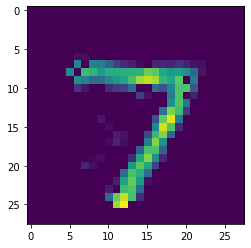

In [16]:
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), 
                loss=tf.losses.mse)

    # run training loop
    sim.fit(train_data, train_data, epochs=n_epochs)

    # evaluate performance on test set
    print("Test error:", sim.evaluate(test_data, test_data))

    # display example output
    output = sim.predict(test_data[:minibatch_size])
    plt.figure()
    plt.imshow(output[p_c][0].reshape((28, 28)));

More details on using `sim.fit` can be found in [the user guide](https://www.nengo.ai/nengo-dl/simulator.html).

## NEF parameter optimization

NengoDL also provides access to a different optimization method, the Neural Engineering Framework (NEF).  This uses linear least-squares optimization to solve for optimal connection weights analytically, rather than using an iterative gradient-descent based algorithm.  The advantage of the NEF is that it is very fast and general (for example, it does not require the network to be differentiable).  The disadvantage is that it optimizes each set of connection weights individually (i.e., it cannot jointly optimize across multiple layers).

The NEF optimization is accessed by setting the `function` argument on a `nengo.Connection`.  This specifies the function that we would like those connection weights to approximate.  In addition, in previous examples you may have noticed that we were forming Connections using `ensemble.neurons` (rather than `ensemble`).  Using `ensemble.neurons` specifies that we want to form a direct connection between ensemble neurons, without applying the NEF optimization.  So when we want to use the `function` argument, the `Connection` source object should be an `ensemble`, not `ensemble.neurons`.  For example, we could use the NEF to create a network to approximate the function $sin(x^2)$:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|######        Constructing graph: build stage (10%)             | ETA: 0:00:00

|##############Constructing graph: build stage (50%)             | ETA: 0:00:00

|##############Constructing graph: build stage (80%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

| #                           Simulating                              | 0:00:00

|######        Constructing graph: build stage (10%)             | ETA: 0:00:00

|##############Constructing graph: build stage (60%)             | ETA: 0:00:00

|  #                          Simulating                              | 0:00:00

|##############Constructing graph: build stage (90%)######       | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|   #                         Simulating                              | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

|          #                  Simulating                              | 0:00:01

|           #                 Simulating                              | 0:00:01

|            #                Simulating                              | 0:00:01

Simulation finished in 0:00:01                                                 

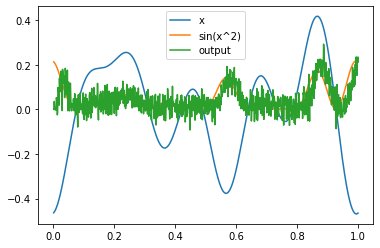

In [17]:
with nengo.Network(seed=0) as net:    
    # input node outputting a random signal for x
    inpt = nengo.Node(nengo.processes.WhiteSignal(1, 5, rms=0.3))
    
    # first ensemble, will compute x^2
    ens0 = nengo.Ensemble(50, 1)
    
    # second ensemble, will compute sin(x^2)
    ens1 = nengo.Ensemble(50, 1)
    
    # output node
    outpt = nengo.Node(size_in=1)
    
    # connect input to first ensemble
    nengo.Connection(inpt, ens0)
    
    # connect first to second ensemble, solve for weights
    # to approximate the square function
    nengo.Connection(ens0, ens1, function=np.square)
    
    # connect second ensemble to output, solve for weights
    # to approximate the sin function
    nengo.Connection(ens1, outpt, function=np.sin)
    
    # add a probe on the input and output
    inpt_p = nengo.Probe(inpt)
    outpt_p = nengo.Probe(outpt)
    
with nengo_dl.Simulator(net, seed=0) as sim:
    sim.run_steps(1000)
    
plt.figure()
plt.plot(sim.trange(), sim.data[inpt_p], label="x")
plt.plot(sim.trange(), np.sin(sim.data[inpt_p]**2), label="sin(x^2)")
plt.plot(sim.trange(), sim.data[outpt_p], label="output")
plt.legend();

The NEF optimization can be used in combination with the deep learning optimization methods.  For example, we could optimize some parameters with the NEF and others with `sim.fit` (see [this example](https://www.nengo.ai/nengo-dl/examples/from-nengo.html)).  Or we could initialize each set of connection weights individually with the NEF, and then further refine them with end-to-end training via `sim.fit`.  As always, the overall theme is that NengoDL allows us to use whichever method is most appropriate for a particular goal.

See [this example](https://www.nengo.ai/nengo/examples/advanced/nef_summary.html) for a deeper introduction to the principles of the NEF.

## Running on neuromorphic hardware

Neuromorphic hardware is specialized compute hardware designed to simulate neuromorphic networks quickly/efficiently.  However, often it is difficult to program this custom hardware, and it requires writing custom code for each neuromorphic platform.  One of the primary design goals of Nengo is to alleviate these challenges, by providing a single API that can be used to build networks across many different neuromorphic platforms.  

The idea is that the front-end network construction code is the same (`Networks`, `Nodes`, `Ensembles`, `Connections`, and `Probes`), and then each platform has its own `Simulator` class (the back-end) that compiles and executes that network definition for some compute platform.  This provides a consistent interface so that we only need to write code once and can then run that network on novel hardware platforms with no additional effort.  For example, we could take the network from above and simulate it on different hardware platforms:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

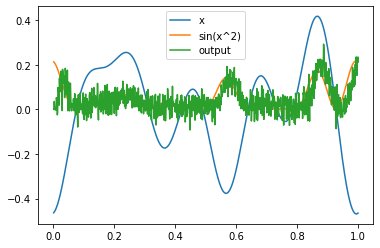

In [18]:
# run on a standard CPU
with nengo.Simulator(net, seed=0) as sim:
    sim.run_steps(1000)
    
# run on Loihi neuromorphic hardware 
# (requires https://www.nengo.ai/nengo-loihi/)
# with nengo_loihi.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

# run on SpiNNaker neuromorphic hardware 
# (requires https://github.com/project-rig/nengo_spinnaker)
# with nengo_spinnaker.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)
    
# run on any OpenCL-compatible hardware
# (requires https://github.com/nengo/nengo-ocl)
# with nengo_ocl.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[inpt_p], label="x")
plt.plot(sim.trange(), np.sin(sim.data[inpt_p]**2), label="sin(x^2)")
plt.plot(sim.trange(), sim.data[outpt_p], label="output")
plt.legend();

We have commented out the different backends above because they require extra installation steps, but if you are running this example yourself you can install any of those backends (or more) and uncomment that code to see the same network running on that new hardware platform.  Note that we can think of NengoDL as a TensorFlow back-end (among other things); it takes a standard Nengo network, and simulates it using TensorFlow.

We can take advantage of this cross-platform compatibility to effectively incorporate NengoDL's deep learning functionality into any other Nengo back-end.  We build our Network, optimize it in NengoDL, save the optimized model parameters back into the Network definition, and then simulate that optimized Network in a different back-end.  See [this example in nengo-loihi](https://www.nengo.ai/nengo-loihi/examples/mnist_convnet.html), where a spiking network is optimized in NengoDL and then deployed on Loihi.

## Conclusion

In this tutorial we have demonstrated how to translate TensorFlow concepts into NengoDL, including network construction, execution, and optimization.  We have also discussed how to use TensorNodes to combine TensorFlow and Nengo code, and introduced some of the unique features of Nengo (such as NEF optimization and neuromorphic cross-platform execution).  However, there is much more functionality in NengoDL than we are able to introduce here; check out the [user guide](https://www.nengo.ai/nengo-dl/user-guide.html) or [other examples](https://www.nengo.ai/nengo-dl/examples.html) for more information.  If you would like more information on how NengoDL is implemented under the hood using TensorFlow, check out the [white paper](https://arxiv.org/abs/1805.11144).